# WarpAffine

In this notebook you'll learn how to use WarpAffine operator.

First, let's import the necessary modules and define the location of the dataset.

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'lmdb')

The functions below define affine transofm matrices for a batch of images. Each image receives its own transform.

In [2]:
def random_transform(index):
    dst_cx, dst_cy = (200,200)
    src_cx, src_cy = (100,100)
    
    # This function uses homogeneous coordinates - hence, 3x3 matrix
    
    # translate output coordinates to center defined by (dst_cx, dst_cy)
    t1 = np.array([[1, 0, -dst_cx],
                   [0, 1, -dst_cy],
                   [0, 0, 1]])
    def u():
        return np.random.uniform(-0.5, 0.5)
    
    # apply a randomized affine transform - identity + some random distortion
    m = np.array([
        [1 + u(),     u(), 0],
        [    u(), 1 + u(), 0],
        [0,       0,       1]])
    
    # translate input coordinates to center (src_cx, src_cy)
    t2 = np.array([[1, 0, src_cx],
                   [0, 1, src_cy],
                   [0, 0, 1]])
    
    # combine the transforms
    m = (np.matmul(t2, np.matmul(m, t1)))
    
    # remove the last row; it's meaningless for an affine transform
    return m[0:2,0:3]


def gen_transforms(batch_size, single_transform_fn):
    out = np.zeros([batch_size, 2, 3])
    for i in range(batch_size):
        out[i,:,:] = single_transform_fn(i)
    return out.astype(np.float32)


Now, let's define the pipeline.

In [3]:
class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, pipelined = True, exec_async = True):
        super(HybridPipe, self).__init__(batch_size, num_threads, device_id, seed = 12, exec_pipelined=pipelined, exec_async=exec_async)
        self.input = ops.CaffeReader(path = db_folder, random_shuffle = True)
        self.decode = ops.ImageDecoder(device = "cpu", output_type = types.RGB)
        
        self.warp_gpu = ops.WarpAffine(
            device = "gpu",
            size = (400,400),                 # specify the output size
          # fill_value                        # not specifying `fill_value`
                                              #   results in source coordinate clamping
            interp_type = types.INTERP_LINEAR # use linear interpolation
        )
        
        self.warp_cpu = ops.WarpAffine(
            device = "cpu",
            fill_value = 200,
            size = (400,400),                 # specify the output size
            interp_type = types.INTERP_NN     # use nearest neighbor interpolation
        )

        self.warp_keep_size = ops.WarpAffine(
            device = "gpu",
          # size                              # keep original canvas size
            interp_type = types.INTERP_LINEAR # use linear interpolation
        )
        
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        
        # This example uses ExternalSource to provide warp matrices
        self.transform_source = ops.ExternalSource()
        self.iter = 0

    def define_graph(self):
        self.transform = self.transform_source()
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        outputs = [images.gpu()]
        # pass the transform parameters through GPU memory
        outputs += [self.warp_gpu(images.gpu(), self.transform.gpu())]
        # pass the transform through a named input
        outputs += [self.warp_cpu(images, matrix = self.transform).gpu()]

        outputs += [self.warp_keep_size(images.gpu(), self.transform.gpu())]

        return [self.labels, self.transform] + outputs

    def iter_setup(self):
        # Generate the transforms for the batch and feed them to the ExternalSource
        self.feed_input(self.transform, gen_transforms(self.batch_size, random_transform))

In [4]:
batch_size = 32

np.random.seed(seed = 123)
pipe = HybridPipe(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

In [5]:
pipe_out = pipe.run()

Warp matrix:
[[  1.1964692   -0.21386066 -96.521706  ]
 [ -0.27314854   1.0513147  -55.633244  ]]


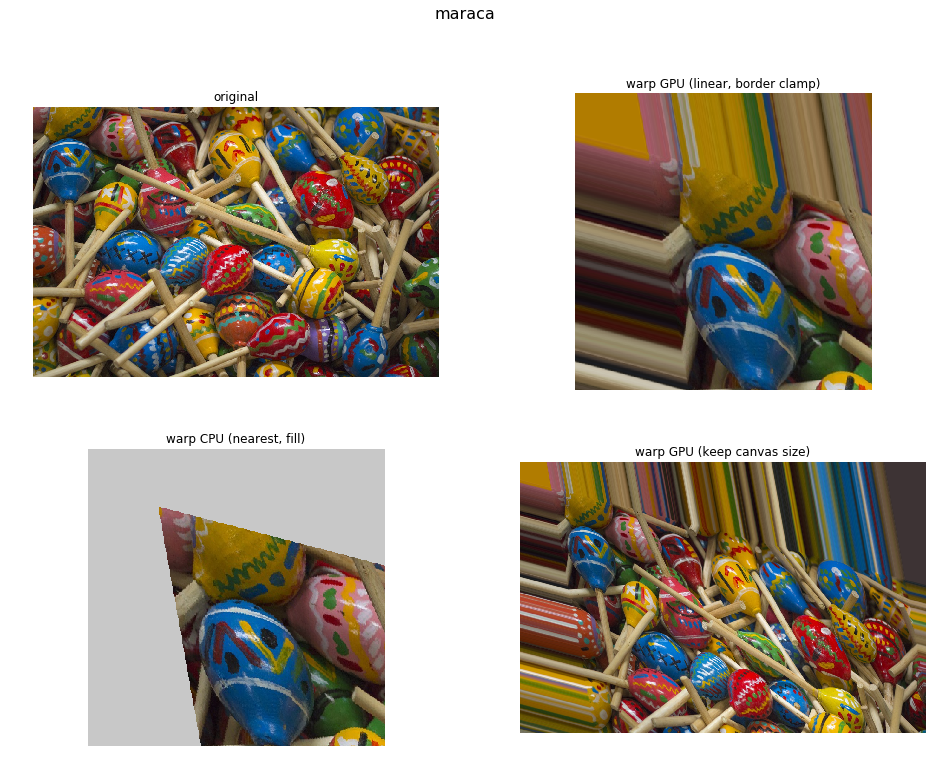

In [6]:
n = 0
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec
len_outputs = len(pipe_out) - 2
augmentations = ["original", "warp GPU (linear, border clamp)", "warp CPU (nearest, fill)", "warp GPU (keep canvas size)"]
fig = plt.figure(figsize = (16,12))
plt.suptitle(imagenet_synsets[pipe_out[0].at(n)[0]], fontsize=16)
columns = 2
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
print("Warp matrix:")
print(pipe_out[1].at(n))
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[2 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw)/255.0)